In [1]:
%reset -f out
%reset -f in
import gc
gc.collect()
import ctypes
libc = ctypes.CDLL("libc.so.6") # clearing cache 
libc.malloc_trim(0)

import logging
#logging.basicConfig(level=logging.CRITICAL)

import matplotlib
if 0:
    import os
    os.environ['OPENBLAS_NUM_THREADS'] = '1'
    os.environ['MKL_NUM_THREADS'] = '1'
    matplotlib.use('tkagg')
import matplotlib.pyplot as plt
plt.rcParams['animation.ffmpeg_path'] = '/usr/bin/ffmpeg'
from matplotlib.colors import LogNorm
import numpy as np
import scipy
import scipy.sparse as sparse
import zfista
from scipy.linalg import khatri_rao, kron
from copy import deepcopy
from tqdm.notebook import tqdm
import time
from copy import deepcopy
import datetime

from ngsolve import *
from bilevel import *
from plotting_utils import *


import random
random.seed(19)
rng = np.random.default_rng(19)

animate_flag = False

Flushing output cache (0 entries)
Flushing input history


In [2]:
actual_noise_level = 1e-2
tol = 1e-15
order = 3
tau = 1.3
use_discrepancy = True

iters = 300#int(1e3)
step_mult = 1

coarse_h = 200
mid_h = 0.05
perfect_h = 0.03
refines = 100
scatterers = 3

omega = 10
c = omega**2/2

domain_is_complex = False

bil = bilevel(maxh = coarse_h, scatterers = scatterers, order = order, \
              omega = omega, domain_is_complex = domain_is_complex)

bil_mid = bilevel(maxh = mid_h, scatterers = scatterers, order = order, \
              omega = omega, domain_is_complex = domain_is_complex)

bil_perfect = bilevel(maxh = perfect_h, scatterers = scatterers, order = order, \
              omega = omega, domain_is_complex = domain_is_complex)

maker = bil.maker
maker_perfect = bil_perfect.maker

mesh = maker.mesh
mesh_copy = deepcopy(mesh)
mesh_perfect = maker_perfect.mesh

fes = maker.fes
cofes = maker.cofes
allfes = maker.allfes

fes_perfect = maker_perfect.fes
cofes_perfect = maker_perfect.cofes
allfes_perfect = maker_perfect.allfes

Current maxh: 0.5308752966697342...
Skipping norm estimation, warning...
Current maxh: 0.06444811741000837...
Skipping norm estimation, warning...
Current maxh: 0.04570685006834525...
Skipping norm estimation, warning...


In [3]:
r = x**2 + y**2
d = 0.5**2 - r
f = IfPos(d, sqrt(d) * cos(2 * pi * sqrt(r)),0)

f_norm = np.real(np.sqrt(np.real(Integrate(f*Conj(f),mesh_perfect.Materials("inner")))))

g = maker_perfect.eval_PDE(f)
g_norm = np.real(np.sqrt(np.real(Integrate(g*Conj(g),mesh_perfect))))

f0 = 0*f

intp = H1(mesh_perfect, order=0, complex = domain_is_complex)
fi = GridFunction(intp)
fi.Set(f)
fmax = np.max(np.abs(fi.vec.FV().NumPy()[:]))

Draw(f, mesh_perfect, min = -fmax, max = fmax, animate_complex = domain_is_complex, settings={"Objects": {"Wireframe": False}})
Draw(g, mesh_perfect, min = -0.01, max = 0.01, animate_complex = True, settings={"Objects": {"Wireframe": False}})

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fals…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fals…

BaseWebGuiScene

In [4]:
## Create additive noise

if actual_noise_level > 0:
    noise_level = actual_noise_level * 1
    noise = GridFunction(maker_perfect.cofes)
    noise.vec.data += rng.normal(size = maker_perfect.cofes.ndof) + 1j * rng.normal(size = maker_perfect.cofes.ndof)

    g_norm = np.sqrt(np.real(Integrate(g*Conj(g),mesh_perfect)))
    noise_norm = np.sqrt(np.real(Integrate(noise*Conj(noise),mesh_perfect)))

    noise_level *= g_norm
    print("Effective noise level",noise_level)
    
    noise.vec.data *= noise_level / noise_norm
else:
    noise_level = 0
    noise = CF(0)

Effective noise level 7.238402944601734e-05


In [5]:
fk = GridFunction(maker.fes, autoupdate = False, nested = False)
fk.Set(f0)

residual = maker.eval_PDE(fk) - (g + noise)

errs = [np.sqrt(np.real(Integrate((fk-f)*Conj(fk-f), mesh_perfect.Materials("inner"))))]
residuals = [np.sqrt(np.real(Integrate(residual*Conj(residual), mesh_perfect.Materials("outer"))))]
times = [0]
laptimes = [0]
updatetimes = [0]
actual_iters = [0]

epsilons = []
if noise_level:
    C = 1.4/noise_level
    q = float(2)**(1/60)#(1/80)
    Cn = C * noise_level
else:
    C = 0.7
    Cn = C
    q = float(2)**(1/80)

success = 0
while not success:
    #bil = bilevel(maxh = coarse_h, scatterers = scatterers, order = order, omega = omega)

    landtime = 0
    updatetime = 0

    j = 0
    J = 0
    ref_flag = True
    stop_flag = False
    epsilon = np.inf
    while not stop_flag:
        if success:
            break
        start_updatetime = time.time()

        if ref_flag:
            #try:
            fk, fk_util = bil.update(fk, refine = J > 0)
            #except:
            #    print("Meshing error...")
            #    break
            #    ref_flag = False

        #gn = GridFunction(bil.allfes)
        #gn.Set(g + noise)
            
        epsilon = bil.h
        epsilons.append(epsilon)

        if epsilon < 0.02:
            ref_flag = False

        mu = step_mult/bil.norm**2
        updatetime = time.time() - start_updatetime
        updatetimes.append(updatetimes[-1] + updatetime)
        
        # Add update time to total time for fairness!
        if J:
            times[-1] += updatetime
        
        print("Updated mesh in " + str(updatetime) + " seconds...")
        laptime = 0
        errtime = 0

        jref = 0
        #print('\r', "eps-bound:", Cn / q**j, end = '\r')
        while epsilon < Cn / q**j or not ref_flag:
            #print('\r', "eps-bound:", C * noise_level / q**j, end = '\r')
            
            start_landtime = time.time()
            
            #residual = bil.eval_PDE(fk) - gn
            residual = bil.eval_PDE(fk) - (g + noise)
            backprop = bil.adjoint_PDE(residual)
            if 0:
                Draw(residual,mesh, animate_complex = animate_flag)
                Draw(backprop,mesh, animate_complex = animate_flag)
                #assert 0
            fk.Set(fk_util - mu * backprop)
            fk_util.Set(fk)

            end_landtime = time.time()

            itertime = end_landtime - start_landtime
            
            landtime += itertime
            laptime += itertime
            
            #times.append(times[-1] + itertime)

            start_errtime = time.time()

            with TaskManager():
                err = np.sqrt(np.real(Integrate((fk-f)*Conj(fk-f), mesh_perfect.Materials("inner"))))
                
                start_restime = time.time()
                res = np.sqrt(np.real(Integrate(residual*Conj(residual), mesh_perfect.Materials("outer"))))
                restime = time.time() - start_restime
                
                errs.append(err)
                residuals.append(res)

            #times[-1] = times[-1] + restime
            times.append(times[-1] + itertime + restime)
            laptime += restime
            errtime += time.time() - start_errtime

            j += 1
            jref += 1

            print('\r', "Residual",res,"vs.",noise_level * tau, end='\r')
            if noise_level and use_discrepancy:
                if res <= noise_level * tau:
                    stop_flag = True
                    print("Discrepancy principle triggered in iteration " + str(j) + ", interrupting...")
                    success = True
                    break
            elif j < iters:
                print('\r',"Current iteration:",j,"out of",iters, end='\r')
            else:
                print("Hit total number of iters, breaking...")
                stop_flag = True
                success = True
                break

        Draw(fk,bil.mesh, min = -fmax, max = fmax)

        print("Refinement " + str(J) + " completed with " + \
              str(jref) + " iterations in " + str(datetime.timedelta(seconds=laptime)) + "...")
        print("Error computation lasted " + str(datetime.timedelta(seconds=errtime)) + "...")
        print("Final residual",res,"vs.",noise_level * tau)
        print("-"*40)
        laptimes.append(laptimes[-1] + laptime)
        actual_iters.append(actual_iters[-1]+jref+1)

        J += 1

    actual_refines = J
    print("Bilevel-Landweber completed in " + str(datetime.timedelta(seconds=laptimes[-1])))
    mesh = bil.mesh
    reco_bilevel = fk
    data_bilevel = bil.eval_PDE(reco_bilevel)
    
errs = np.array(errs) / f_norm
residuals = np.array(residuals) / g_norm

Current maxh: 0.5308752966697342...
Skipping norm estimation, warning...
Updated mesh in 0.023325443267822266 seconds...


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

Refinement 0 completed with 84 iterations in 0:00:02.346303...
Error computation lasted 0:00:02.241364...
Final residual 0.0007808164115911644 vs. 9.409923827982254e-05
----------------------------------------
Current maxh: 0.2654376483348671...
Skipping norm estimation, warning...
Updated mesh in 0.03182268142700195 seconds...


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

Refinement 1 completed with 60 iterations in 0:00:02.183986...
Error computation lasted 0:00:01.942564...
Final residual 0.0001779616511498432 vs. 9.409923827982254e-05
----------------------------------------
Current maxh: 0.13901968269704068...
Skipping norm estimation, warning...
Updated mesh in 0.03217649459838867 seconds...


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

Refinement 2 completed with 56 iterations in 0:00:03.495403...
Error computation lasted 0:00:02.235141...
Final residual 0.00010037655527518186 vs. 9.409923827982254e-05
----------------------------------------
Current maxh: 0.0797574258739645...
Skipping norm estimation, warning...
Updated mesh in 0.09581971168518066 seconds...
Discrepancy principle triggered in iteration 216, interrupting...


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

Refinement 3 completed with 16 iterations in 0:00:01.631759...
Error computation lasted 0:00:00.880893...
Final residual 9.392471519717216e-05 vs. 9.409923827982254e-05
----------------------------------------
Bilevel-Landweber completed in 0:00:09.657451


In [6]:
Draw(f, mesh_perfect, min = -fmax, max = fmax, animate_complex = animate_flag)
Draw(reco_bilevel, mesh, min = -fmax, max = fmax, animate_complex = animate_flag)
Draw(f-reco_bilevel,mesh_perfect.Materials("inner"), animate_complex = animate_flag)

Draw(g, mesh_perfect, animate_complex = animate_flag)
Draw(data_bilevel, mesh, animate_complex = animate_flag)
Draw(g-data_bilevel,mesh_perfect.Materials("outer"), animate_complex = animate_flag)
Draw(mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Complex': {'phase': 0.0, 'sp…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Complex': {'phase': 0.0, 'sp…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Complex': {'phase': 0.0, 'sp…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Complex': {'phase': 0.0, 'sp…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Complex': {'phase': 0.0, 'sp…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Complex': {'phase': 0.0, 'sp…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [7]:
#compare_with = "last"
compare_with = "mid"
#compare_with = "perfect"

if compare_with == "last":
    comp_bil = bil
elif compare_with == "mid":
    comp_bil = bil_mid
else:
    comp_bil = bil_perfect
    
comp_fes = comp_bil.fes
comp_mesh = comp_bil.mesh

fk = GridFunction(comp_fes, autoupdate = False, nested = False)
fk.Set(f0)

fk_util = GridFunction(comp_fes, autoupdate = False, nested = False)
fk_util.Set(fk)

residual = comp_bil.eval_PDE(fk) - (g + noise)

directerrs = [np.sqrt(np.real(Integrate((fk-f)*Conj(fk-f), mesh_perfect.Materials("inner"))))]
directresiduals = [np.sqrt(np.real(Integrate(residual*Conj(residual), mesh_perfect.Materials("outer"))))]
directtimes = [0]

directtime = 0

mu = step_mult/comp_bil.norm**2
j = 0

flag_time = False
flag_disc = not use_discrepancy

while not flag_time or not flag_disc:#directtime < landtime:
    start_directtime = time.time()
    residual = comp_bil.eval_PDE(fk) - (g + noise)
    backprop = comp_bil.adjoint_PDE(residual)

    fk.Set(fk_util - mu * backprop)
    fk_util.Set(fk)

    end_directtime = time.time()
    
    itertime = end_directtime - start_directtime
    directtime += itertime
    #directtimes.append(directtimes[-1] + itertime)
    
    err = np.sqrt(np.real(Integrate((fk-f)*Conj(fk-f), mesh_perfect.Materials("inner"))))

    start_restime = time.time()
    res = np.sqrt(np.real(Integrate(residual*Conj(residual), mesh_perfect.Materials("outer"))))
    restime = time.time() - start_restime
    
    #directtimes[-1] = directtimes[-1] + restime
    directtimes.append(directtimes[-1] + itertime + restime)
    
    if directtimes[-1] > times[-1]:
        fk_time = fk*1
        flag_time = True
    
    directerrs.append(err)
    directresiduals.append(res)
    
    if noise_level and not flag_disc:
        print('\r',"Residual",res,"vs.",noise_level * tau,end='\r')
        if res <= noise_level * tau:
            #stop_flag = True
            print("Discrepancy principle triggered in iteration " + str(j) + ", interrupting...")
            #break
            flag_disc = True
    
    elif j < iters:
        print('\r',"Current iteration:",j,"out of",iters,end='\r')
    else:
        print("Hit total number of iters, breaking...")
        stop_flag = True
        success = True
        break
            
    j += 1


reco_direct_time = fk_time
reco_direct = fk
data_direct = comp_bil.eval_PDE(fk)

directerrs = np.array(directerrs) / f_norm
directresiduals = np.array(directresiduals) / g_norm

Discrepancy principle triggered in iteration 159, interrupting...


In [8]:
Draw(f, mesh_perfect, min = -fmax, max = fmax, animate_complex = animate_flag)
Draw(reco_direct_time, comp_mesh, min = -fmax, max = fmax, animate_complex = animate_flag)
Draw(reco_direct, comp_mesh, min = -fmax, max = fmax, animate_complex = animate_flag)
Draw(f-reco_direct,mesh.Materials("inner"), animate_complex = animate_flag)

Draw(g, mesh_perfect, animate_complex = animate_flag)
Draw(data_direct, mesh, animate_complex = animate_flag)
Draw(g-data_direct,mesh.Materials("outer"), animate_complex = animate_flag)
Draw(mesh)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Complex': {'phase': 0.0, 'sp…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Complex': {'phase': 0.0, 'sp…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Complex': {'phase': 0.0, 'sp…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Complex': {'phase': 0.0, 'sp…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Complex': {'phase': 0.0, 'sp…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Complex': {'phase': 0.0, 'sp…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Complex': {'phase': 0.0, 'sp…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

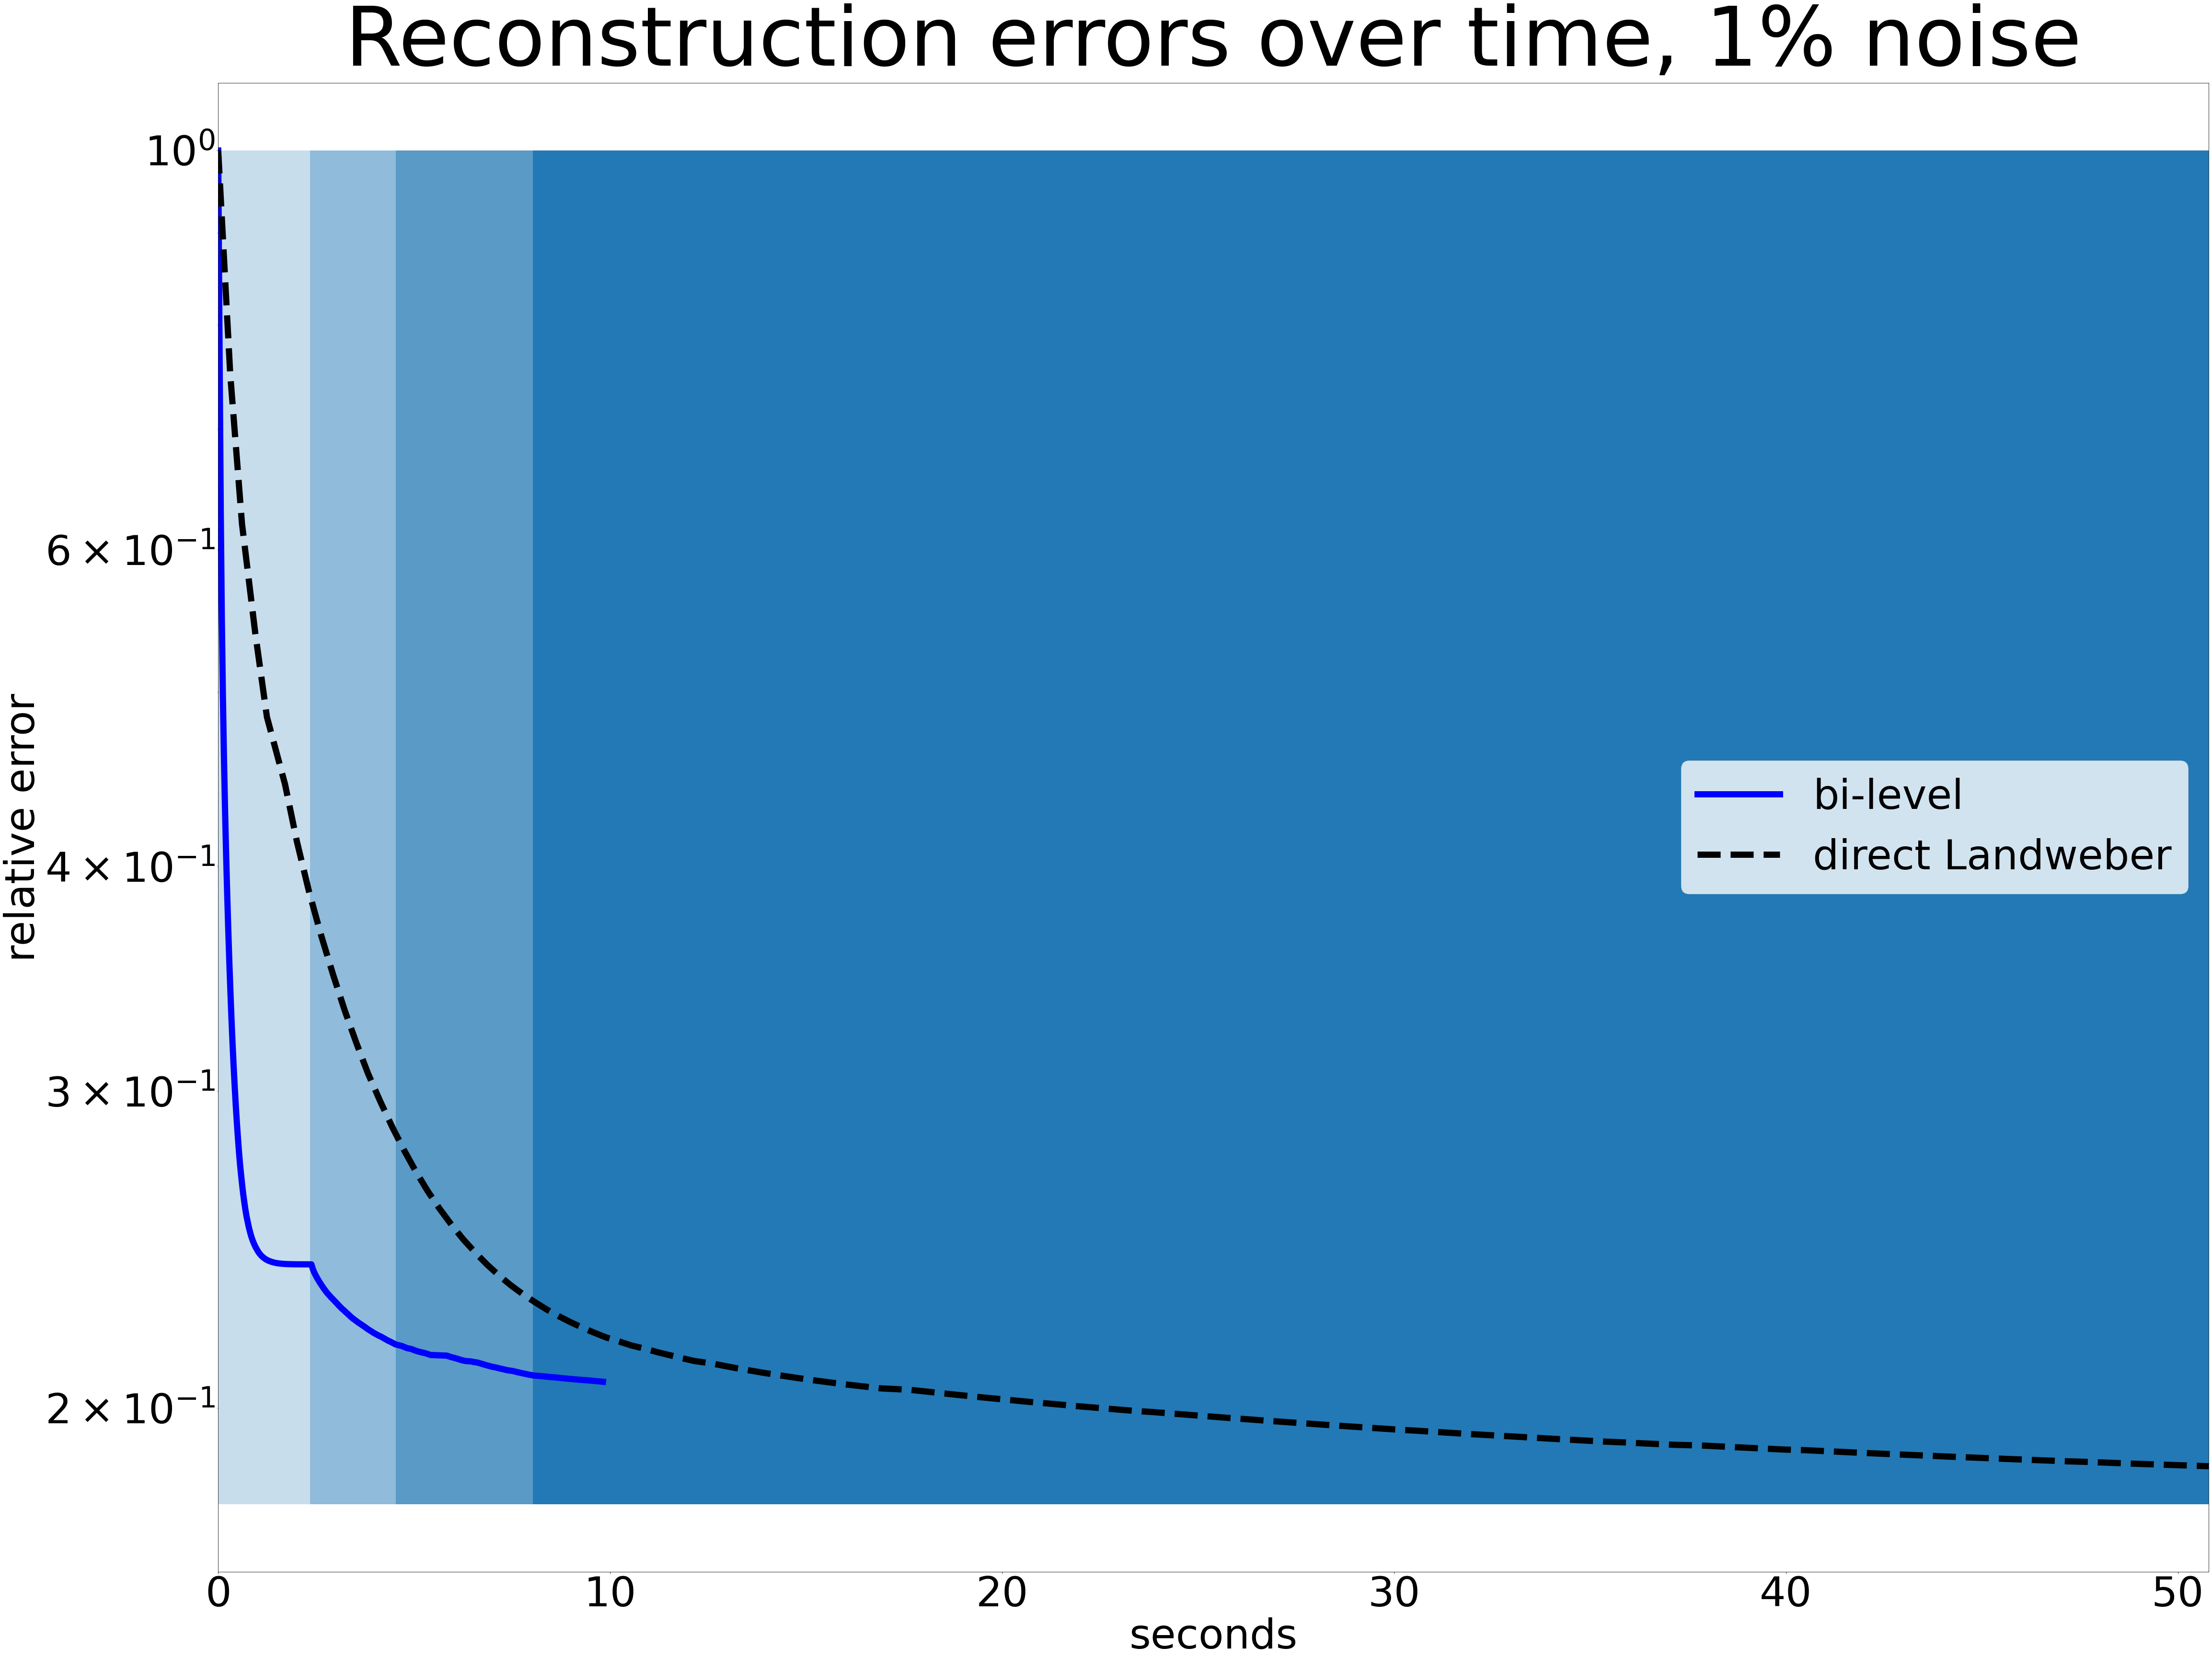

In [9]:
plot_with_boxes(t1 = times, x1 = errs, t2 = directtimes, x2 = directerrs, \
                n_boxes = actual_refines, pos_boxes = laptimes, desc = "Reconstruction errors over time", \
                c = 'b', noise = actual_noise_level)
#plt.yscale("log")
#plt.ylim(1e-10,3)
plt.show()

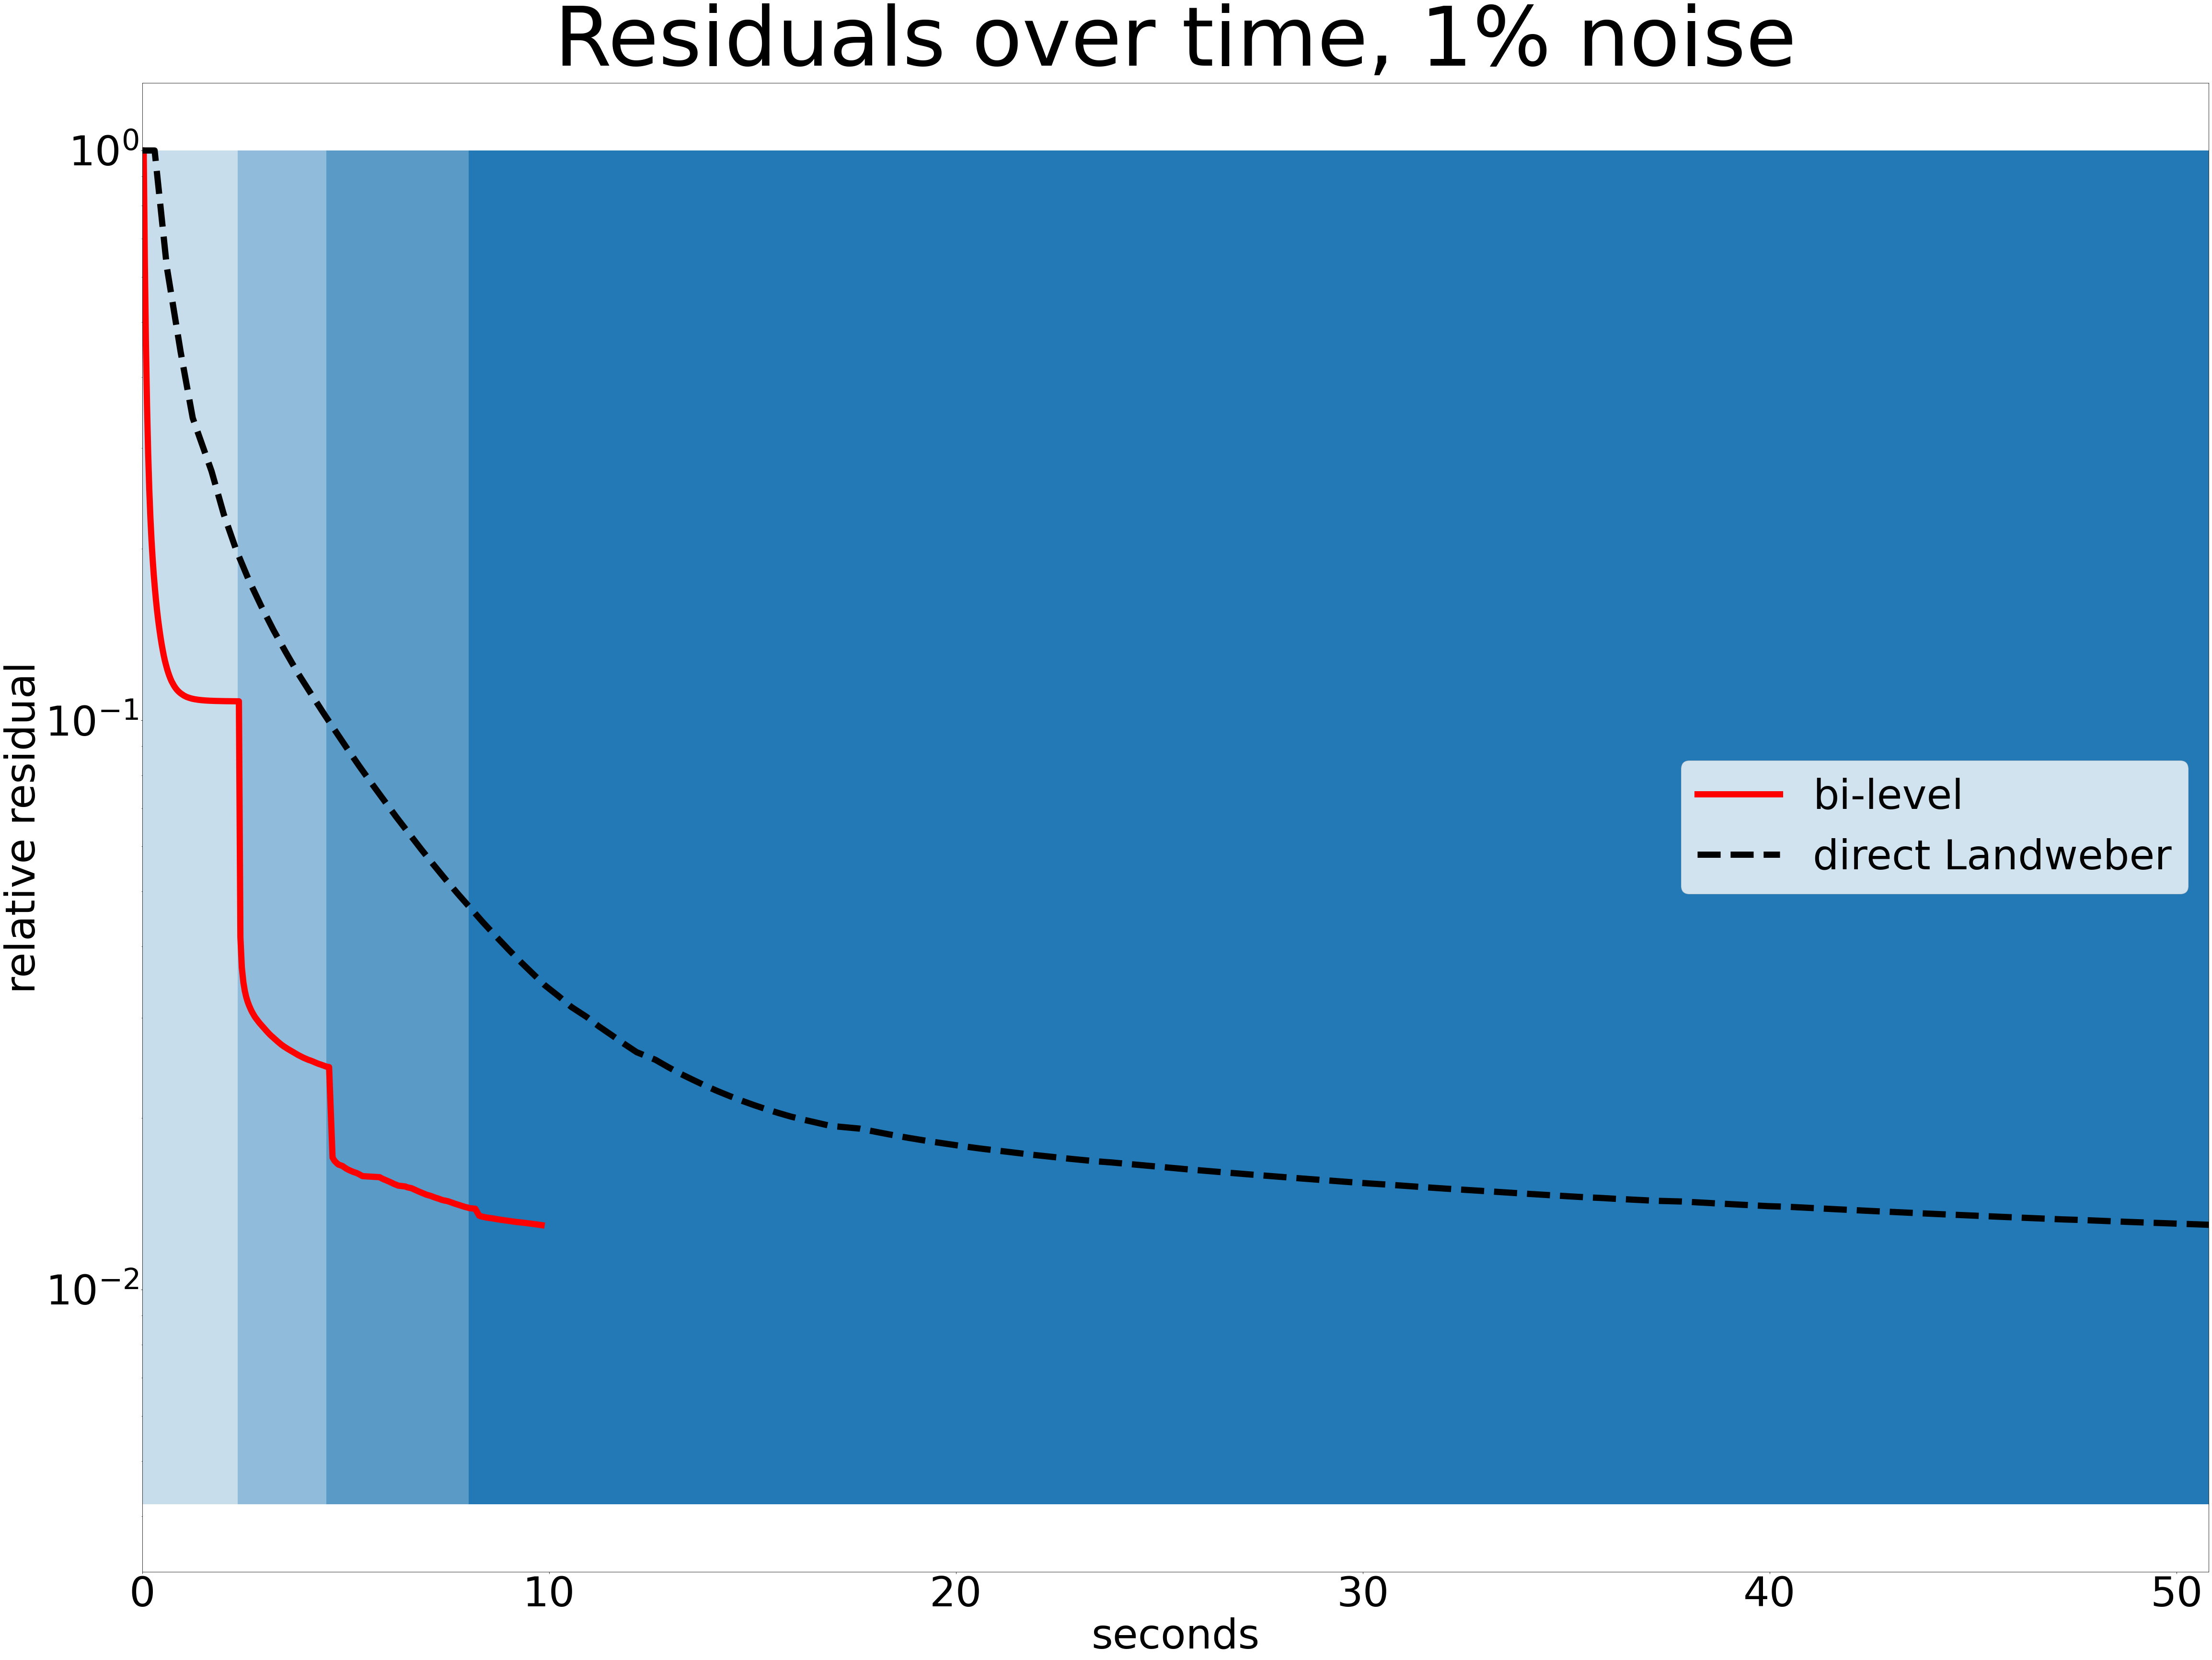

In [10]:
plot_with_boxes(t1 = times, x1 = residuals, t2 = directtimes, x2 = directresiduals, \
                n_boxes = actual_refines, pos_boxes = laptimes, desc = "Residuals over time", c = 'r', noise = actual_noise_level)
plt.show()

In [11]:
Draw(reco_bilevel, mesh, min = -fmax, max = fmax, animate_complex = True, settings={"Objects": {"Wireframe": False}})
Draw(reco_direct_time, comp_mesh, min = -fmax, max = fmax, animate_complex = True, settings={"Objects": {"Wireframe": False}})
Draw(reco_direct, comp_mesh, min = -fmax, max = fmax, animate_complex = True, settings={"Objects": {"Wireframe": False}})
Draw(f-reco_bilevel,mesh, min = -2*fmax/3, max = 2*fmax/3, animate_complex = True)
Draw(f-reco_direct, comp_mesh, min = -2*fmax/3, max = 2*fmax/3, animate_complex = True)

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fals…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fals…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fals…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Complex': {'phase': 0.0, 'sp…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Complex': {'phase': 0.0, 'sp…

BaseWebGuiScene

In [12]:
errs

array([1.        , 0.75723762, 0.62844344, 0.55015026, 0.49752902,
       0.45926403, 0.42964618, 0.40562371, 0.38549049, 0.36824498,
       0.35326463, 0.34013707, 0.32857102, 0.31834814, 0.30929636,
       0.30127457, 0.2941636 , 0.28786067, 0.28227583, 0.27732962,
       0.27295144, 0.26907831, 0.26565397, 0.26262814, 0.2599559 ,
       0.2575971 , 0.25551598, 0.25368061, 0.25206264, 0.25063681,
       0.24938075, 0.24827457, 0.24730067, 0.24644349, 0.24568923,
       0.24502571, 0.24444219, 0.24392914, 0.2434782 , 0.24308196,
       0.24273391, 0.24242829, 0.24216003, 0.24192466, 0.24171824,
       0.24153731, 0.2413788 , 0.24124003, 0.24111861, 0.24101245,
       0.24091971, 0.24083876, 0.24076818, 0.24070669, 0.2406532 ,
       0.24060671, 0.24056636, 0.2405314 , 0.24050115, 0.24047502,
       0.24045249, 0.2404331 , 0.24041645, 0.24040218, 0.24038998,
       0.24037957, 0.24037071, 0.24036318, 0.2403568 , 0.2403514 ,
       0.24034684, 0.240343  , 0.24033975, 0.240337  , 0.24033

In [13]:
directerrs

array([1.        , 0.75132208, 0.62023251, 0.53926211, 0.48430507,
       0.44416945, 0.41304134, 0.38776868, 0.36658099, 0.34843621,
       0.33268367, 0.31888918, 0.30674329, 0.296012  , 0.28650962,
       0.27808328, 0.27060373, 0.26395963, 0.25805388, 0.25280113,
       0.24812595, 0.24396152, 0.24024857, 0.2369345 , 0.23397265,
       0.23132164, 0.22894486, 0.22680989, 0.2248881 , 0.2231542 ,
       0.2215859 , 0.22016356, 0.21886989, 0.21768968, 0.21660954,
       0.21561774, 0.21470394, 0.21385908, 0.21307521, 0.21234533,
       0.21166333, 0.21102382, 0.21042207, 0.20985396, 0.20931583,
       0.20880449, 0.20831714, 0.20785131, 0.20740483, 0.20697579,
       0.20656253, 0.20616356, 0.20577758, 0.20540345, 0.20504015,
       0.2046868 , 0.20434259, 0.20400683, 0.20367891, 0.20335827,
       0.20304443, 0.20273695, 0.20243544, 0.20213957, 0.20184901,
       0.2015635 , 0.20128279, 0.20100665, 0.20073488, 0.2004673 ,
       0.20020374, 0.19994405, 0.1996881 , 0.19943576, 0.19918

In [14]:
times

[0,
 0.03801298141479492,
 0.06560373306274414,
 0.09227991104125977,
 0.11982393264770508,
 0.1474757194519043,
 0.17508578300476074,
 0.2027580738067627,
 0.23043107986450195,
 0.2579071521759033,
 0.28520679473876953,
 0.31314730644226074,
 0.34006690979003906,
 0.3674314022064209,
 0.39514827728271484,
 0.42304062843322754,
 0.45022130012512207,
 0.47742486000061035,
 0.5048456192016602,
 0.5314865112304688,
 0.5585165023803711,
 0.5871667861938477,
 0.6143538951873779,
 0.641585111618042,
 0.6691310405731201,
 0.6963005065917969,
 0.7236158847808838,
 0.7532398700714111,
 0.7808704376220703,
 0.8090636730194092,
 0.8368968963623047,
 0.8651013374328613,
 0.8952357769012451,
 0.9243273735046387,
 0.9535212516784668,
 0.9840857982635498,
 1.0113756656646729,
 1.0383942127227783,
 1.066565752029419,
 1.094175100326538,
 1.124183177947998,
 1.1538245677947998,
 1.1826179027557373,
 1.2105846405029297,
 1.238309383392334,
 1.2686917781829834,
 1.2974321842193604,
 1.3271615505218506,
 

In [15]:
print(Integrate((f-reco_bilevel)*Conj(f-reco_bilevel),mesh_perfect))
print(Integrate((f-reco_direct)*Conj(f-reco_direct),mesh_perfect))

print(Integrate((f-reco_bilevel)*Conj(f-reco_bilevel),mesh))
print(Integrate((f-reco_direct)*Conj(f-reco_direct),mesh))

0.001461012921598486
0.0011769392584070975
0.0014636550223563205
0.0011799626856772505


In [16]:
print(Integrate((g-data_bilevel)*Conj(g-data_bilevel),mesh_perfect))
print(Integrate((g-data_direct)*Conj(g-data_direct),mesh_perfect))

print(Integrate((g-data_bilevel)*Conj(g-data_bilevel),mesh))
print(Integrate((g-data_direct)*Conj(g-data_direct),mesh))

(3.559392111581992e-09-1.2531873310880506e-28j)
(3.586797494403999e-09+2.9923218808206817e-28j)
(3.556597679642182e-09-1.750063284846865e-28j)
(3.58883371012217e-09-3.496786500534143e-28j)


In [17]:
help(mesh)

Help on Mesh in module ngsolve.comp object:

class Mesh(pybind11_builtins.pybind11_object)
 |  NGSolve interface to the Netgen mesh. Provides access and functionality
 |  to use the mesh for finite element calculations.
 |  
 |  Parameters:
 |  
 |  mesh (netgen.Mesh): a mesh generated from Netgen
 |  
 |  Method resolution order:
 |      Mesh
 |      pybind11_builtins.pybind11_object
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  BBBoundaries(...)
 |      BBBoundaries(self: ngsolve.comp.Mesh, pattern: str) -> ngsolve.comp.Region
 |      
 |      Return co dim 3 boundary mesh-region matching the given regex pattern
 |  
 |  BBoundaries(...)
 |      BBoundaries(self: ngsolve.comp.Mesh, pattern: str) -> ngsolve.comp.Region
 |      
 |      Return co dim 2 boundary mesh-region matching the given regex pattern
 |  
 |  Boundaries(...)
 |      Boundaries(*args, **kwargs)
 |      Overloaded function.
 |      
 |      1. Boundaries(self: ngsolve.comp.Mesh, pattern: str) -> ng

In [18]:
residuals

array([1.00004386, 1.00004386, 0.63861247, 0.4582845 , 0.35656763,
       0.29435357, 0.25406332, 0.22655908, 0.20675936, 0.19177738,
       0.17995227, 0.17030825, 0.16225285, 0.15541052, 0.14953117,
       0.14443959, 0.14000693, 0.13613432, 0.1327431 , 0.12976894,
       0.12715799, 0.1248645 , 0.1228491 , 0.12107766, 0.1195204 ,
       0.11815127, 0.11694741, 0.11588874, 0.11495762, 0.11413853,
       0.11341784, 0.11278355, 0.11222514, 0.11173335, 0.11130007,
       0.11091817, 0.1105814 , 0.11028425, 0.11002192, 0.10979019,
       0.10958534, 0.10940413, 0.1092437 , 0.10910156, 0.10897551,
       0.10886362, 0.1087642 , 0.10867576, 0.10859701, 0.1085268 ,
       0.10846412, 0.10840809, 0.10835792, 0.10831295, 0.10827256,
       0.10823622, 0.10820348, 0.10817391, 0.10814717, 0.10812293,
       0.10810091, 0.10808086, 0.10806256, 0.10804583, 0.10803048,
       0.10801638, 0.10800339, 0.10799138, 0.10798026, 0.10796994,
       0.10796033, 0.10795135, 0.10794296, 0.10793508, 0.10792

In [19]:
elvol = Integrate(CoefficientFunction(1),mesh,element_wise=True)
h = [(2*vol)**(1/2) for vol in elvol]
h

[0.04301419238070963,
 0.053526114331665625,
 0.04076904137573741,
 0.050601927212640375,
 0.0469195021434179,
 0.04631959510581895,
 0.062160296301938596,
 0.04802892533581406,
 0.06334714192551923,
 0.06033149749051039,
 0.05588698069730965,
 0.05231669439609619,
 0.03948294049703571,
 0.0438816973524461,
 0.04103189945416231,
 0.06032248638828108,
 0.056397016685463625,
 0.04334073860138614,
 0.04617905510493752,
 0.05335273773216975,
 0.04571489382782637,
 0.053989645268989785,
 0.04621128079563201,
 0.04864182707550428,
 0.04325006697604042,
 0.05043999225694835,
 0.057720889294322855,
 0.04455661890057137,
 0.0574276381021129,
 0.06421045878105845,
 0.0536730941874681,
 0.04868254469343422,
 0.05170274495985421,
 0.05172786362959896,
 0.05048546988402516,
 0.04607741438392386,
 0.050268675908145675,
 0.0415407132619534,
 0.047464352965762596,
 0.04504546493789086,
 0.041620265148678615,
 0.04238238596132554,
 0.03991253509748044,
 0.03273481830292959,
 0.03236687817980481,
 0.033

In [20]:
print(times)

[0, 0.03801298141479492, 0.06560373306274414, 0.09227991104125977, 0.11982393264770508, 0.1474757194519043, 0.17508578300476074, 0.2027580738067627, 0.23043107986450195, 0.2579071521759033, 0.28520679473876953, 0.31314730644226074, 0.34006690979003906, 0.3674314022064209, 0.39514827728271484, 0.42304062843322754, 0.45022130012512207, 0.47742486000061035, 0.5048456192016602, 0.5314865112304688, 0.5585165023803711, 0.5871667861938477, 0.6143538951873779, 0.641585111618042, 0.6691310405731201, 0.6963005065917969, 0.7236158847808838, 0.7532398700714111, 0.7808704376220703, 0.8090636730194092, 0.8368968963623047, 0.8651013374328613, 0.8952357769012451, 0.9243273735046387, 0.9535212516784668, 0.9840857982635498, 1.0113756656646729, 1.0383942127227783, 1.066565752029419, 1.094175100326538, 1.124183177947998, 1.1538245677947998, 1.1826179027557373, 1.2105846405029297, 1.238309383392334, 1.2686917781829834, 1.2974321842193604, 1.3271615505218506, 1.3555786609649658, 1.3838305473327637, 1.412981

In [21]:
print(directtimes)

[0, 0.30646395683288574, 0.606874942779541, 0.9450936317443848, 1.243283987045288, 1.706690788269043, 2.0067057609558105, 2.3108913898468018, 2.620112419128418, 2.9276609420776367, 3.2269790172576904, 3.5291941165924072, 3.825047731399536, 4.137014389038086, 4.441455125808716, 4.744916200637817, 5.044894695281982, 5.345265865325928, 5.649472713470459, 5.9538044929504395, 6.253687381744385, 6.561271905899048, 6.860568046569824, 7.163898229598999, 7.4669578075408936, 7.7753684520721436, 8.085369348526001, 8.385127782821655, 8.691471338272095, 8.99491286277771, 9.296793699264526, 9.601550102233887, 9.895882606506348, 10.240888833999634, 10.546288967132568, 10.925495147705078, 11.2305006980896, 11.5558762550354, 11.855713367462158, 12.154350519180298, 12.61465311050415, 12.918952941894531, 13.218241930007935, 13.53316879272461, 13.832244634628296, 14.13571834564209, 14.439613819122314, 14.740251541137695, 15.03957486152649, 15.340874910354614, 15.64203691482544, 15.942857503890991, 16.2761

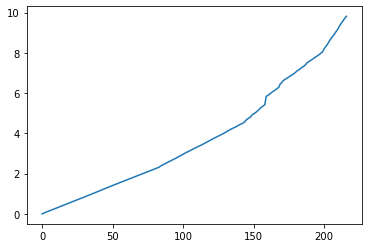

In [22]:
plt.plot(times)

In [23]:
err_bilevel = f-reco_bilevel
err_direct = f-reco_direct

intp = H1(mesh_perfect, order=0, complex = domain_is_complex)

fi_bilevel = GridFunction(intp)
fi_bilevel.Set(err_bilevel)
errmax = np.max(np.abs(fi_bilevel.vec.FV().NumPy()[:]))

fi_direct = GridFunction(intp)
fi_direct.Set(err_direct)
errmax = max(errmax,np.max(np.abs(fi_direct.vec.FV().NumPy()[:])))

errmax = 0.373

Draw(f-reco_bilevel,mesh_perfect.Materials("inner"), min = -errmax, max = errmax, settings={"Objects": {"Wireframe": False}})
Draw(f-reco_direct,mesh_perfect.Materials("inner"), min = -errmax, max = errmax, settings={"Objects": {"Wireframe": False}})

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fals…

WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {'Objects': {'Wireframe': Fals…

BaseWebGuiScene